In [1]:
import numpy as np
import torch
from library.GCN import *
from pathlib import Path
from torch.utils.data import DataLoader,SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
import itertools

Test $R^2$, MAE and RMSE of each outer fold

In [2]:
#### Inputs
max_atoms = 30 # fixed value
node_vec_len = 16 # fixed value
batch_size = 256
hidden_nodes = 128
n_conv_layers = 4
n_hidden_layers = 2
learning_rate = 0.003
n_epochs = 50
use_GPU = False

model = ChemGCN(node_vec_len=node_vec_len,
                node_fea_len=hidden_nodes,
                hidden_fea_len=hidden_nodes,
                n_conv=n_conv_layers,
                n_hidden=n_hidden_layers,
                n_outputs=1,
                p_dropout=0.1)

#### Start by creating dataset
main_path = Path.cwd().parents[0]
data_path = main_path / "data" / "RDKit" / "rdkit_only_valid_smiles_qm9.pkl"
dataset = GraphData(dataset_path=data_path, max_atoms=max_atoms, 
                        node_vec_len=node_vec_len)

state_dict = torch.load(
    main_path / 'data' / 'GCN' / 'GCN_outer_fold_weights' / 'GCN_weight_outer_fold_0.pth',
    map_location='cpu'
)

model.load_state_dict(state_dict)

dataset_indices = np.arange(0, len(dataset), 1)

#### Split data into training and test sets

y = np.array([float(dataset[i][1]) for i in range(len(dataset))])

num_bins = 10
gap_bins_outer = pd.qcut(y, q=num_bins, labels=False)

outer_seed = 42
inner_seed = 123

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=outer_seed)

temp = outer_cv.split(dataset_indices, gap_bins_outer)
outer_fold_splits = [x for x in temp]

mae_outer_folds = []
loss_outer_folds = []
r2_outer_folds = []
targets_outer_folds = []
predictions_outer_folds = []

for outer_fold_idx in range(5):
    train_val_idx = outer_fold_splits[outer_fold_idx][0]
    test_idx = outer_fold_splits[outer_fold_idx][1]

    # Create dataloader
    test_loader = DataLoader(dataset, batch_size=batch_size, 
                            sampler=SubsetRandomSampler(test_idx),
                            collate_fn=collate_graph_dataset)
    
    
    outputs = [float(dataset[i][1]) for i in range(len(dataset))]
    standardizer = Standardizer(torch.Tensor(outputs))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    train_losses = []
    train_maes = []

    # Test the outer fold
    test_loss, test_mae, test_r2, test_targets, test_predictions = test_model(
        model, test_loader, loss_fn, standardizer,
        use_GPU, max_atoms, node_vec_len
    )
    
    loss_outer_folds.append(test_loss)
    mae_outer_folds.append(test_mae)
    r2_outer_folds.append(test_r2)
    targets_outer_folds.append(test_targets)
    predictions_outer_folds.append(test_predictions)
    
    print(f'Evaluation of outer fold {outer_fold_idx+1} finished.')

Evaluation of outer fold 1 finished.
Evaluation of outer fold 2 finished.
Evaluation of outer fold 3 finished.
Evaluation of outer fold 4 finished.
Evaluation of outer fold 5 finished.


MAE:

In [3]:
for i in range(5):
    print(f'MAE of outer fold {i+1} = {mae_outer_folds[i]}')
print(f'\nMean MAE of all outer folds = {np.mean(mae_outer_folds)}')

MAE of outer fold 1 = 0.16767899426493313
MAE of outer fold 2 = 0.1585183609830271
MAE of outer fold 3 = 0.15665805221784232
MAE of outer fold 4 = 0.15850784297626797
MAE of outer fold 5 = 0.15868236213037284

Mean MAE of all outer folds = 0.16000912251448868


RMSE:

In [4]:
RMSE_outer_folds = [np.sqrt(loss) for loss in loss_outer_folds]
for i in range(5):
    print(f'RMSE of outer fold {i+1} = {RMSE_outer_folds[i]}')
print(f'\nMean RMSE of all outer folds = {np.mean(RMSE_outer_folds)}')

RMSE of outer fold 1 = 0.24040902000119685
RMSE of outer fold 2 = 0.22804968354866656
RMSE of outer fold 3 = 0.22546095089763832
RMSE of outer fold 4 = 0.22304491787133657
RMSE of outer fold 5 = 0.23008619498330782

Mean RMSE of all outer folds = 0.2294101534604292


$R^2$:

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_pred_vs_true(y_true, y_pred, r2=None):
    """
    y_true, y_pred: list of arrays (length 5)
    r2: list of R^2 values (length 5) or None
    """

    fig = plt.figure(figsize=(14, 8))

    # MANY columns → flexible spanning
    gs = GridSpec(nrows=2, ncols=12, figure=fig)

    # Define subplot spans (row, col_start:col_end)
    axes = [
        fig.add_subplot(gs[0, 0:4]),   # Fold 1
        fig.add_subplot(gs[0, 4:8]),   # Fold 2
        fig.add_subplot(gs[0, 8:12]),  # Fold 3
        fig.add_subplot(gs[1, 2:6]),   # Fold 4 (centered)
        fig.add_subplot(gs[1, 6:10])   # Fold 5 (centered)
    ]

    for i, ax in enumerate(axes):
        yt = np.array(y_true[i])
        yp = np.array(y_pred[i])

        min_val = min(yt.min(), yp.min())
        max_val = max(yt.max(), yp.max())

        ax.scatter(yt, yp, s=12, alpha=0.6)
        ax.plot(
            [min_val, max_val],
            [min_val, max_val],
            "--",
            color="red",
            linewidth=1.2,
            label="y = x" if i == 0 else None
        )

        ax.set_xlabel("True HOMO-LUMO Gap (eV)")
        ax.set_ylabel("Predicted HOMO-LUMO Gap (eV)")
        ax.set_title(f"Outer Fold {i + 1}")

        if r2 is not None:
            ax.text(
                0.05, 0.95,
                f"$R^2$ = {r2[i]:.4f}",
                transform=ax.transAxes,
                fontsize=11,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", edgecolor="black")
            )

    axes[0].legend()
    plt.tight_layout()
    plt.show()


In [6]:
print(fr'Mean $R^2$ = {np.mean(r2_outer_folds)}')

Mean $R^2$ = 0.9678822003582868


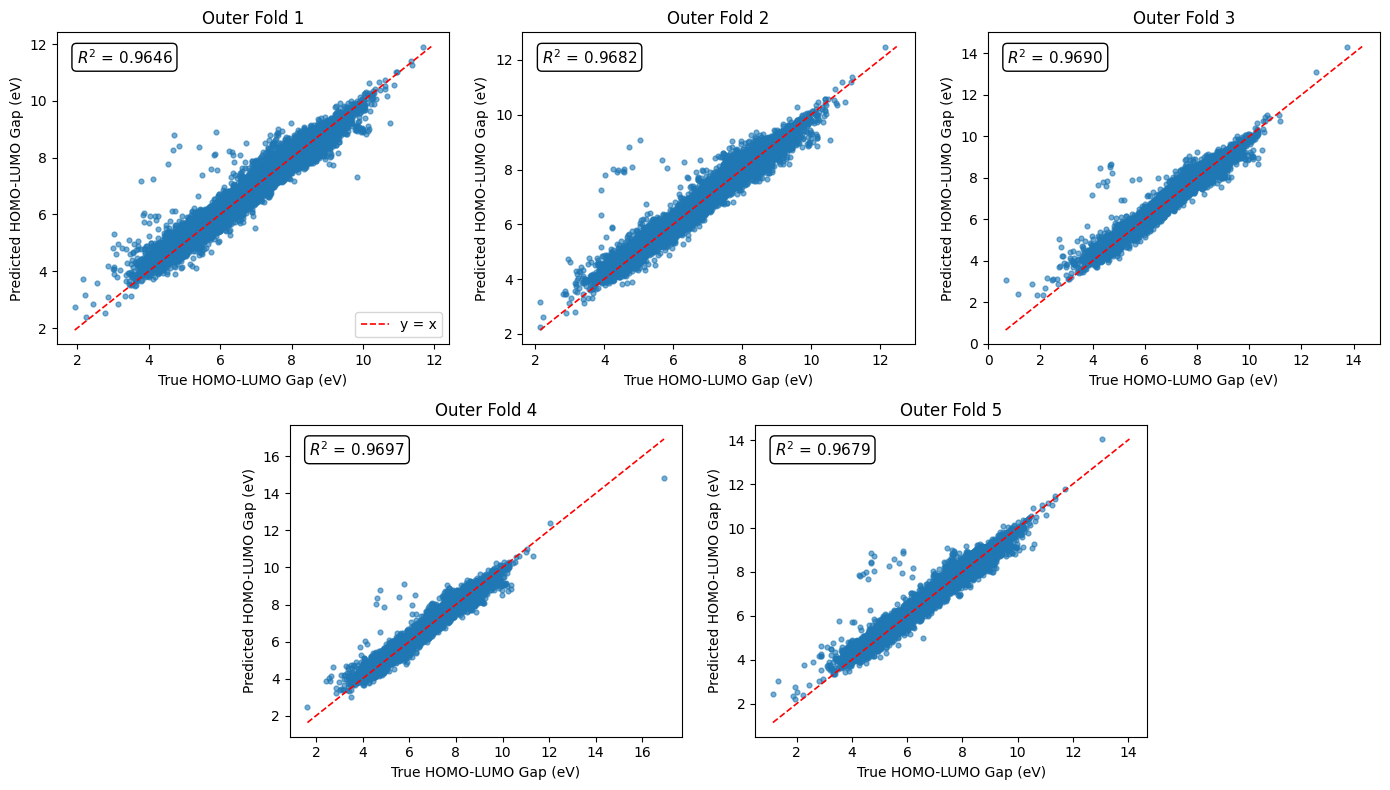

In [16]:

plot_pred_vs_true(targets_outer_folds,predictions_outer_folds,r2_outer_folds)